In [28]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cornac
from cornac.eval_methods import RatioSplit
from cornac.hyperopt import Discrete, Continuous
from cornac.hyperopt import GridSearch, RandomSearch
from cornac.metrics import AUC, FMeasure, MAE, MRR, NCRR, NDCG, Precision, Recall, RMSE
from cornac.models import BPR


FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


In [2]:
# Load train dataset
final_data = pd.read_csv("/Users/oleksiizirka/Desktop/Studies/Master of AI - SMU/_Semester 3/Recommender Systems/Group Project/train_ratings_seen.csv")
final_data.head()

,user_id,item_id,rating
0,34297304,1260259,4.0
1,34297304,1137544,3.0
2,34297304,1372673,1.0
3,34297304,2511537,3.0
4,34297304,92537,4.0


In [3]:
for col in final_data:
    print(len(final_data[col].unique()))


5066
39520
9


In [30]:
# Load test dataset
test_ratings_unseen = pd.read_csv("/Users/oleksiizirka/Desktop/Studies/Master of AI - SMU/_Semester 3/Recommender Systems/Group Project/test_ratings_unseen.csv")
test_ratings_unseen_df = pd.DataFrame(test_ratings_unseen, columns=["user_id", "item_id", "rating"])
print(test_ratings_unseen_df.shape)
test_ratings_unseen_df.head()

(22492, 3)


,user_id,item_id,rating
0,34297304,1205151,1.0
1,34297304,19481,3.0
2,34297304,1251093,4.0
3,34297304,24169,2.0
4,34297304,1221087,2.0


In [31]:
# Concatenate the data sets
both_df = pd.concat([final_data, test_ratings_unseen_df], ignore_index=True, axis=0)
print(both_df.shape)
both_df.head()

(142414, 3)


,user_id,item_id,rating
0,34297304,1260259,4.0
1,34297304,1137544,3.0
2,34297304,1372673,1.0
3,34297304,2511537,3.0
4,34297304,92537,4.0


### Data Analysis

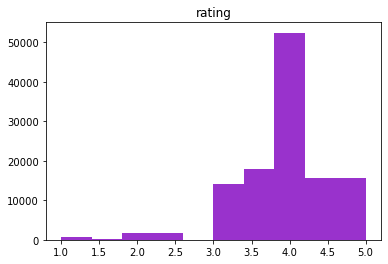

In [4]:
# Distribution of grades in the dataset
visual = final_data.hist(column='rating', grid=False, color = "darkorchid")

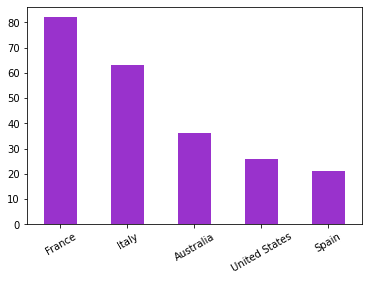

In [5]:
# Build some visualizations from JSON
json_data = pd.read_json('wine-info.json')
visual_json = json_data['country_name'].value_counts().iloc[:5].plot(kind='bar', color = "darkorchid", rot=30)


In [6]:
json_data.head()

,wine_id,wine_url,wine_name,producer,region_name,country_name,average_rating,nr_ratings,wine_image_url,food_pairings,wine_style
0,28114,/SG/en/miguel-torres-chile-conde-de-superunda/...,Conde de Superunda,Miguel Torres Chile,Curico Valley,Chile,4.2,224,//images.vivino.com/thumbs/dEru-zx8Q8erQGPgveo...,[],None
1,1217181,/SG/en/saltram-shiraz-no-1/w/1217181?year=1998,Shiraz No. 1,Saltram,Barossa,Australia,4.5,49,//images.vivino.com/thumbs/neL_r-oZSZCNjOWzehU...,"[Beef, Lamb, Game (deer, venison), Poultry]",Australian Shiraz
2,1184502,/SG/en/santa-margherita-pinot-grigio-valdadige...,Pinot Grigio Valdadige,Santa Margherita,Valdadige,Italy,4.0,4870,//images.vivino.com/thumbs/W0id9D39TXW_hRUjpEJ...,"[Shellfish, Vegetarian, Mushrooms, Aperitif]",Northern Italy Pinot Grigio
3,7840326,/SG/en/wills-domain-eightfold-chardonnay/w/784...,Eightfold Chardonnay,Wills Domain,Margaret River,Australia,0.0,6,//images.vivino.com/thumbs/gtnfnYRvTgm3OUeTV8D...,"[Pork, Rich fish (salmon, tuna etc), Vegetaria...",Australian Chardonnay
4,19085,/SG/en/de-bortoli-noble-one-botrytis-semillon/...,Noble One Botrytis Sémillon,De Bortoli,Riverina,Australia,4.3,36,//images.vivino.com/thumbs/S8aSy4QIRPygEils8QF...,[],None


## Approach 0 - MostPop

In [22]:
trial = final_data.groupby('item_id').agg(['count','mean'])

In [23]:
toper = trial.rating.sort_values(by=['count', 'mean'], ascending=False)

In [25]:
toper.head(10)

,count,mean
item_id,,
1652,225,4.551111
1135843,224,4.133929
7103,181,4.284530
18978,164,4.015244
14362,159,4.408805
75626,153,4.225490
7972,147,4.312925
5078,144,4.593750
75190,143,4.297203


## Approach 1a - SVD (with Cornac)

In [37]:
# Set seed

USE_SEED = True

if USE_SEED:
    SEED = 42
else:
    SEED = None
    
VERBOSE = True


In [33]:
# Turn the datasets into tuples

# Train
train_tuples = []
for row in final_data.itertuples(index=False, name=None):
    train_tuples.append(row)

# Test
probe_tuples = []
for row in test_ratings_unseen_df.itertuples(index=False, name=None):
    probe_tuples.append(row)

# Both
both_tuples = []
for row in both_df.itertuples(index=False, name=None):
    both_tuples.append(row)


In [35]:
# Create Cornac datasets

train_cornac = cornac.data.Dataset.from_uir(final_data.itertuples(index=False))
test_cornac = cornac.data.Dataset.from_uir(test_ratings_unseen_df.itertuples(index=False))
both_cornac = cornac.data.Dataset.from_uir(both_df.itertuples(index=False))

/opt/anaconda3/lib/python3.9/site-packages/cornac/data/dataset.py:361: UserWarning: 772 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


In [36]:
# Create lists of user ids

user_ids_train = final_data.user_id.unique()
user_ids_test = test_ratings_unseen_df.user_id.unique()
user_ids_both = both_df.user_id.unique()

# Create lists of items ids

item_ids_train = final_data.item_id.unique()
item_ids_test = test_ratings_unseen_df.item_id.unique()
item_ids_both = both_df.item_id.unique()

In [38]:
data=train_tuples
rs = RatioSplit(data, test_size=0.1, val_size=0.1, seed=SEED, verbose=VERBOSE)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 5066
Number of items = 34404
Number of ratings = 95936
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9
---
Test data:
Number of users = 3710
Number of items = 5451
Number of ratings = 9303
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 3713
Number of items = 5472
Number of ratings = 9286
---
Total users = 5066
Total items = 34404


In [39]:
# Define the metrics to evaluate the models:

metrics = [
  cornac.metrics.RMSE(),
  cornac.metrics.FMeasure(k=20),
  cornac.metrics.AUC(),
  cornac.metrics.MRR(),
  cornac.metrics.NCRR(k=20),
  cornac.metrics.NDCG(k=20),
  cornac.metrics.Recall(k=20)
]

In [41]:
# Define the base model

svd=cornac.models.svd.recom_svd.SVD(
  k=50, #The dimension of the latent factors.
  max_iter=100, # Maximum number of iterations or the number of epochs for SGD.
  learning_rate=0.001, # The learning rate for SGD.
  lambda_reg=0.001, # The regularization hyper-parameter.
  num_threads=0, # Number of parallel threads for training. If num_threads=0, all CPU cores will be utilized. If seed is not None, num_threads=1 to remove randomness from parallelization.
  trainable=True, # When False, the model will not be re-trained, and input of pre-trained parameters are required.
  verbose=True, # When True, some running logs are displayed.
  init_params=None, # Initial parameters, e.g., init_params = {‘U’: user_factors, ‘V’: item_factors, ‘Bi’: item_biases}.
  seed=SEED, # Random seed for weight initialization. If specified, training will take longer because of single-thread (no parallelization)
)

### Grid Search

In [42]:
gs_svd = cornac.hyperopt.GridSearch(
  model=svd,
  space=[
         Discrete("k", [10, 20, 30, 40, 50, 75, 100]),
         Discrete("max_iter", [50, 100, 200, 400]),
         Discrete("learning_rate", [0.001, 0.002, 0.005, 0.010]),
         Discrete("lambda_reg", [0.001, 0.002, 0.005, 0.010]),
  ],
  metric=cornac.metrics.Recall(k=20),
  eval_method=rs,
)

cornac.Experiment(
  eval_method=rs,
  models=[gs_svd],
  metrics=metrics,
  user_based=True,
  save_dir='cornac_experiments',
).run()


[GridSearch_SVD] Training started!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Best parameter settings: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}
Recall@20 = 0.0154

[GridSearch_SVD] Evaluation started!


Rating:   0%|          | 0/9303 [00:00<?, ?it/s]

Ranking:   0%|          | 0/3710 [00:00<?, ?it/s]

Rating:   0%|          | 0/9286 [00:00<?, ?it/s]

Ranking:   0%|          | 0/3713 [00:00<?, ?it/s]

GridSearch_SVD model is saved to cornac_experiments/GridSearch_SVD/2022-06-16_10-36-36-930361.pkl

VALIDATION:
...
               |   RMSE |    AUC |  F1@20 |    MRR | NCRR@20 | NDCG@20 | Recall@20 | Time (s)
-------------- + ------ + ------ + ------ + ------ + ------- + ------- + --------- + --------
GridSearch_SVD | 0.4992 | 0.5738 | 0.0032 | 0.0108 |  0.0045 |  0.0073 |    0.0154 |  17.6170

TEST:
...
               |   RMSE |    AUC |  F1@20 |    MRR | NCRR@20 | NDCG@20 | Recall@20 | Train (s) | Test (s)
-------------- + ------ + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
GridSearch_SVD | 0.4900 | 0.5737 | 0.0034 | 0.0111 |  0.0045 |  0.0075 |    0.0167 | 7658.2419 |  17.6941



In [44]:
# Best parameter settings: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}

### Random Search

In [43]:
rs_svd = cornac.hyperopt.RandomSearch(
  model=svd,
  space=[
         Discrete("k", [35, 40, 45]),
         Discrete("max_iter", [150, 200, 250]),
         Continuous("learning_rate", low=0.005, high=0.02),
         Continuous("lambda_reg", low=0.005, high=0.02),
  ],
  metric=cornac.metrics.RMSE(),
  eval_method=rs,
  n_trails=100,
)

cornac.Experiment(
  eval_method=rs,
  models=[rs_svd],
  metrics=metrics,
  user_based=True,
  save_dir='cornac_experiments',
).run()


[RandomSearch_SVD] Training started!
Evaluating: {'k': 45, 'lambda_reg': 0.016948144802903492, 'learning_rate': 0.007751521847992457, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.007340279606636548, 'learning_rate': 0.00733991780504304, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01799264218662403, 'learning_rate': 0.014016725176148132, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005846173685406504, 'learning_rate': 0.01582998158400237, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005011681487615215, 'learning_rate': 0.019883173389368264, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.012871346474483566, 'learning_rate': 0.011479175279631736, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01417779342083569, 'learning_rate': 0.007092407909780628, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.006359096517992312, 'learning_rate': 0.01427579013999631, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005696756190799966, 'learning_rate': 0.014113172778521574, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005975773894779193, 'learning_rate': 0.0192332830588, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.010781247538098742, 'learning_rate': 0.005239493783303213, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015248952782381874, 'learning_rate': 0.014149949866739314, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01863980603118173, 'learning_rate': 0.008881699724000254, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.012801020317667163, 'learning_rate': 0.013200654190149194, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.01954376941646838, 'learning_rate': 0.016626992350416717, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.018422410256414733, 'learning_rate': 0.013968499682166277, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.007939742936287178, 'learning_rate': 0.005678409333658071, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.00907023547660844, 'learning_rate': 0.01743106263727894, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.009214017645310713, 'learning_rate': 0.013140441247373728, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.017032954711310593, 'learning_rate': 0.006118259655196563, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.01658367153944986, 'learning_rate': 0.007980735223012587, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.007982636061332078, 'learning_rate': 0.01567012929122975, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.014089399621715171, 'learning_rate': 0.018894513177700235, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.018724395133156713, 'learning_rate': 0.01775057866684699, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005953375254290355, 'learning_rate': 0.009664734825734933, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.013869466815615905, 'learning_rate': 0.009120826894850963, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.010743903121306847, 'learning_rate': 0.019575681430836555, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.0158259428174731, 'learning_rate': 0.008539773796234336, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.00560650384307647, 'learning_rate': 0.015659943345286812, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.011590047527986551, 'learning_rate': 0.008025788035030942, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.0097153397161449, 'learning_rate': 0.01262856036747054, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.008739383437233125, 'learning_rate': 0.011155743845534445, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.008431972482374338, 'learning_rate': 0.006154698647431895, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.007418319308810066, 'learning_rate': 0.018945464785138595, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.014501056347656353, 'learning_rate': 0.018071908852815764, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.013090133628734759, 'learning_rate': 0.017111602327460937, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01860242662318631, 'learning_rate': 0.00908198374076953, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005007805654929738, 'learning_rate': 0.010288532845012535, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.007469837797144126, 'learning_rate': 0.013011341290631629, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015386540493354056, 'learning_rate': 0.009041185006977821, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.00984804398031133, 'learning_rate': 0.012781859326150492, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.0059733837066347235, 'learning_rate': 0.00880873120901517, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01245872758838578, 'learning_rate': 0.009513174647251545, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.009001715214129274, 'learning_rate': 0.019649224337489793, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.009179696963549172, 'learning_rate': 0.018623988289499804, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.007173423081368346, 'learning_rate': 0.012341791404163445, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015082033211088176, 'learning_rate': 0.016424294229930764, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015923245229177894, 'learning_rate': 0.010516746990788799, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.010982366636668295, 'learning_rate': 0.01724647809829076, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.009811700974576038, 'learning_rate': 0.007797777655997814, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.013863394147823626, 'learning_rate': 0.015163465427634235, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.012681395874489215, 'learning_rate': 0.00839743662796907, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015364066071536987, 'learning_rate': 0.010801030194508062, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015135351755589211, 'learning_rate': 0.01602824178861158, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.013121719607413488, 'learning_rate': 0.01543676599017623, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.019732525149941532, 'learning_rate': 0.012749538369065214, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.019943805496368865, 'learning_rate': 0.019481290269331906, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.018239545147840094, 'learning_rate': 0.007830606625120692, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015505367449591568, 'learning_rate': 0.017699917133574588, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.014630474692314314, 'learning_rate': 0.0062620994749257326, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.0051379557742494445, 'learning_rate': 0.006522073142990482, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.00507592375769328, 'learning_rate': 0.0074121207712624804, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.0153784279653904, 'learning_rate': 0.014779418892539007, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005271130454232813, 'learning_rate': 0.01240840572775152, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.014864193384505151, 'learning_rate': 0.013524629050032076, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.014544989272788432, 'learning_rate': 0.008756927279083762, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.019683392874125134, 'learning_rate': 0.012301132294391826, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.016922169553124727, 'learning_rate': 0.012539556396577882, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.007928644816970667, 'learning_rate': 0.01583678172892258, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.016528310214594635, 'learning_rate': 0.005654056576316506, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.009193405126951378, 'learning_rate': 0.018252410333993885, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.01892477843881588, 'learning_rate': 0.011422762224759714, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.019454299656338794, 'learning_rate': 0.017795141832010402, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.010776465929028879, 'learning_rate': 0.017767050072752852, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.013352018936875251, 'learning_rate': 0.019042321612411713, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.013550917551340476, 'learning_rate': 0.006457647406561528, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.010379701719442459, 'learning_rate': 0.00881245473604608, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.009838261463579008, 'learning_rate': 0.017730046923870115, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015633664953651778, 'learning_rate': 0.013292299653618615, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.011296712846694148, 'learning_rate': 0.00884310415391687, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005077772941609802, 'learning_rate': 0.014418416224229541, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.016936890041541516, 'learning_rate': 0.018350080127263493, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.010633744289599161, 'learning_rate': 0.006409729097613035, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.005539134106951131, 'learning_rate': 0.011983970271986902, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.009298118781924266, 'learning_rate': 0.013862498908535161, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005560222831238216, 'learning_rate': 0.017339008409894874, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.006905907689778272, 'learning_rate': 0.012833648900822066, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.011858977424205927, 'learning_rate': 0.01763034612517972, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015492683161507908, 'learning_rate': 0.00707529638626702, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.012744505224517928, 'learning_rate': 0.009844347094118688, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.011502811063711132, 'learning_rate': 0.01616063964498673, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.007765005114970551, 'learning_rate': 0.006213094499257965, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015327498511480495, 'learning_rate': 0.005872903932626654, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.011635283445966565, 'learning_rate': 0.00859681038736105, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.014902960650765969, 'learning_rate': 0.009199008454189143, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.014856669927502501, 'learning_rate': 0.011535093480168367, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.005715741915374732, 'learning_rate': 0.013490558157411143, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.006802469717084633, 'learning_rate': 0.010128195000746024, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.005610932034784552, 'learning_rate': 0.01783190876016511, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.016450466345058663, 'learning_rate': 0.01710369465576169, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Best parameter settings: {'k': 40, 'lambda_reg': 0.007939742936287178, 'learning_rate': 0.005678409333658071, 'max_iter': 150}
RMSE = 0.6031

[RandomSearch_SVD] Evaluation started!


Rating:   0%|          | 0/9303 [00:00<?, ?it/s]

Ranking:   0%|          | 0/3710 [00:00<?, ?it/s]

Rating:   0%|          | 0/9286 [00:00<?, ?it/s]

Ranking:   0%|          | 0/3713 [00:00<?, ?it/s]

RandomSearch_SVD model is saved to cornac_experiments/RandomSearch_SVD/2022-06-16_10-44-09-159323.pkl

VALIDATION:
...
                 |   RMSE |    AUC |  F1@20 |    MRR | NCRR@20 | NDCG@20 | Recall@20 | Time (s)
---------------- + ------ + ------ + ------ + ------ + ------- + ------- + --------- + --------
RandomSearch_SVD | 0.5056 | 0.5559 | 0.0001 | 0.0009 |  0.0002 |  0.0003 |    0.0006 |  17.3921

TEST:
...
                 |   RMSE |    AUC |  F1@20 |    MRR | NCRR@20 | NDCG@20 | Recall@20 | Train (s) | Test (s)
---------------- + ------ + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
RandomSearch_SVD | 0.4986 | 0.5563 | 0.0002 | 0.0010 |  0.0002 |  0.0004 |    0.0008 |   87.8469 |  17.3526



In [45]:
# Best parameter settings: {'k': 40, 'lambda_reg': 0.007939742936287178, 'learning_rate': 0.005678409333658071, 'max_iter': 150}

## Approach 1b - SVD (without Cornac)

In [7]:
# Original Rating Matrix
#dataset = cornac.data.Dataset.from_uir(train_df.itertuples(index=False))
#df = pd.DataFrame(dataset.matrix.A,
#                  index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
#                  columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])
df = final_data.pivot_table(columns='item_id', index='user_id', values='rating').reset_index()
df.replace(0, np.nan, inplace=True)
df["Mean Rating"] = df.mean(axis=1)
df = df.set_index('user_id')


In [8]:
data = df.fillna(0)
data = data.drop("Mean Rating", axis=1)
data.head()


item_id,115,142,199,451,452,457,550,603,617,618,...,10722541,10723279,10723340,10726364,10727790,10728742,10732200,10732599,10732635,10734831
user_id,,,,,,,,,,,,,,,,,,,,,
82744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
R = data.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [13]:
print(R_demeaned.shape)

(5066, 39520)


In [14]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)

In [15]:
sigma = np.diag(sigma)

In [16]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = data.columns)

In [17]:
preds_df.head()

item_id,115,142,199,451,452,457,550,603,617,618,...,10722541,10723279,10723340,10726364,10727790,10728742,10732200,10732599,10732635,10734831
0,0.000472,0.008699,-0.007122,0.000982,-0.003643,0.004387,0.003941,0.015895,-0.009445,0.006266,...,0.003332,-0.007629,-0.002832,-0.002832,0.000244,-0.006864,-0.001380,0.000234,0.000234,0.000900
1,-0.000361,0.008001,0.000633,0.004312,0.023332,-0.005869,-0.002890,0.000197,-0.001138,0.000180,...,0.001558,-0.000781,-0.001179,-0.001179,0.000518,0.000731,-0.000359,0.000925,0.000925,0.000813
2,-0.010711,0.000401,0.020400,0.003778,0.005170,0.007562,-0.007793,-0.004374,0.002783,-0.002843,...,-0.003031,-0.001405,-0.001239,-0.001239,-0.000760,0.003335,-0.002455,0.000994,0.000994,-0.000049
3,0.005476,0.002638,0.000682,0.001852,-0.001370,0.002424,0.003007,0.002833,0.004697,0.003450,...,0.001272,0.003127,0.001077,0.001077,0.001664,0.001317,0.000414,0.001631,0.001631,0.001563
4,0.005404,-0.000717,0.006601,0.002266,-0.001590,0.002131,0.003142,0.033131,0.001055,-0.000845,...,-0.000093,0.000636,0.000201,0.000201,-0.000361,0.029195,-0.001249,0.001396,0.001396,0.000002


In [18]:
print(len(data))

5066


In [19]:
def recommend_movies(predictions_df, userID):
    
    # Get and sort the user's predictions
    
    #1 Approach
    #user_row_number = userID - 1 # UserID starts at 1, not 0
    #sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    #print(user_row_number)
    
    #checking = sorted_user_predictions.to_frame()
    #checking.reset_index(inplace=True)
    #top_50 = checking.iloc[0:50, [0]]
    #top_50_id = top_50['index'].tolist()
    #numbers = []
    #for item in top_50_id:
    #    for subitem in item.split():
    #        if(subitem.isdigit()):
    #            numbers.append(subitem)
    
    
    #2 Approach
    sorted_user_predictions = predictions_df.iloc[userID].sort_values(ascending=False)
    
    checking = sorted_user_predictions.to_frame()
    top_50 = checking.iloc[0:50, [0]]
    top_50_id = top_50.index.tolist()
    
    
    final_list.append(top_50_id)
    
    return final_list

final_list = []
for i in range(len(data)):
    predictions = recommend_movies(preds_df, i)

In [20]:
print(predictions[1])

[1684223, 1655970, 1127795, 1152755, 3908, 1148747, 10175, 1166837, 98195, 77137, 1605285, 9220, 1179539, 1168676, 1099373, 1984446, 1098912, 16778, 1126214, 1122095, 1103239, 82779, 1286354, 22447, 2446729, 1099307, 80472, 22917, 1663328, 6020, 1651, 768733, 61744, 12687, 5078, 1197490, 7069, 83446, 18978, 3110, 5313010, 12393, 4588479, 1153863, 1136930, 95444, 22685, 1166785, 18980, 84065]


In [43]:
output = pd.DataFrame(predictions)

In [44]:
output.head(5)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1652,1911534,1214739,6139455,1675,1202838,66294,15615,1869,1506422,...,5080,1849316,1742205,18556,1380075,2847407,1690693,73673,79262,3347644
1,1684223,1655970,1127795,1152755,3908,1166837,10175,1605285,1179539,98195,...,79762,1663328,78405,5313010,3102815,1153828,9530,779367,61754,1197490
2,21585,1126214,1182136,12393,74771,1157632,73660,1122095,9530,1366312,...,1182229,1611475,1141560,8244674,73757,1142886,1182747,7122486,1104824,5080
3,1306,1620784,9530,1146984,1995,1110421,1135980,4091,3736213,1135067,...,2020444,1210789,1115658,2317507,80696,1708521,1152438,97125,2224976,1234333
4,1480684,1380075,73660,5310954,4091,21646,1110421,3347644,1126214,1139111,...,1270666,80650,6818813,1142441,1145413,1179603,1128252,77149,1133793,768733


In [45]:
#output.to_csv("output.csv") 